In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import threading

# Accessing Google Drive
drive.mount('/content/drive')
mypath = "/content/drive/My Drive/Colab Notebooks/DS2Project/"
# For inspection purposes, feel free to change the 'mypath' variable to match
# the path in your own google drive to use the dataset

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv(mypath + "Data/cleanedData.csv")
df

,Date,State,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,NSW,Albury,13.4,22.9,0.6,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,No,No
1,2008-12-02,NSW,Albury,7.4,25.1,0.0,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,No,No
2,2008-12-03,NSW,Albury,12.9,25.7,0.0,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,No,No
3,2008-12-04,NSW,Albury,9.2,28.0,0.0,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,No,No
4,2008-12-05,NSW,Albury,17.5,32.3,1.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119812,2017-06-20,NT,Uluru,3.5,21.8,0.0,E,31.0,ESE,E,15.0,13.0,59.0,27.0,1024.7,1021.2,9.4,20.9,No,No
119813,2017-06-21,NT,Uluru,2.8,23.4,0.0,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,10.1,22.4,No,No
119814,2017-06-22,NT,Uluru,3.6,25.3,0.0,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,10.9,24.5,No,No
119815,2017-06-23,NT,Uluru,5.4,26.9,0.0,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,12.5,26.1,No,No


#Quick Data Maintenence

Some of the columns need to be adjusted from their catergorical valriables to dummy variables in order to be understood by some of the classification methods

- Let's make date parasable, which will allow us to assign a season to each row. Seasons will be replaced by 0-3 for Summer - Spring respectively.

In [ ]:
df['Date'] = pd.to_datetime(df.Date)

def getSeason(month):
  if month == 12 or month == 1 or month == 2:
    #summer
    return 0
  elif month == 3 or month == 4 or month == 5:
    #fall
    return 1
  elif month == 6 or month == 7 or month == 8:
    #winter
    return 2
  elif month == 9 or month == 10 or month == 11:
    #spring
    return 3

monthHolder = []
for i in range(df.shape[0]):
  monthHolder.append(getSeason(df.loc[i, 'Date'].month))

df['Seasons'] = monthHolder
del monthHolder

- Next we would like to replace the wind direction attributes with numeric values. This can be done by replacing the Caridinal direction given a number from 0-360 degrees clockwise when alligned with a compass.

- The following cell should only ever be run once as it directly replaces in the main dataframe.

In [ ]:
def replace_val(dir):
  if dir == "N":
    return 0.0
  elif dir == "NNE":
    return 22.5 
  elif dir == "NE":
    return 45.0
  elif dir == "ENE":
    return 67.5
  elif dir == "E":
    return 90.0
  elif dir == "ESE":
    return 112.5
  elif dir == "SE":
    return 135.0
  elif dir == "SSE":
    return 157.5
  elif dir == "S":
    return 180.0
  elif dir == "SSW":
    return 202.5
  elif dir == "SW":
    return 225.0
  elif dir == "WSW":
    return 247.5
  elif dir == "W":
    return 270.0
  elif dir == "WNW":
    return 292.5
  elif dir == "NW":
    return 315.0
  elif dir == "NNW":
    return 337.5

def col_replace(col, out):
  for i in range(df.shape[0]):
    out.append(replace_val(df.loc[i, col]))
  return out

targetCols = ['WindGustDir', 'WindDir9am', 'WindDir3pm']
outGust = []
out9am = []
out3pm = []
outList = [outGust, out9am, out3pm]

threads = list()
for index in range(len(targetCols)):
  x = threading.Thread(target=col_replace, args=(targetCols[index],outList[index],))
  threads.append(x)
  x.start()

for index, thread in enumerate(threads):
  print("Waiting on", index)
  thread.join()
  print(index, "Done")

for index in range(len(targetCols)):
  df[targetCols[index]] = outList[index]

Waiting on 0
0 Done
Waiting on 1
1 Done
Waiting on 2
2 Done


In [ ]:
# Some quick cleanup
del targetCols
del outGust
del out9am
del out3pm
del threads

In [ ]:
df = df.drop(columns=['Temp9am', 'Temp3pm'])
df = df.apply(lambda x:x.fillna(x.value_counts().index[0]))

In [ ]:
df

,Date,State,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,RainToday,RainTomorrow,Seasons
0,2008-12-01,NSW,Albury,13.4,22.9,0.6,270.0,44.0,270.0,292.5,20.0,24.0,71.0,22.0,1007.7,1007.1,No,No,0
1,2008-12-02,NSW,Albury,7.4,25.1,0.0,292.5,44.0,337.5,247.5,4.0,22.0,44.0,25.0,1010.6,1007.8,No,No,0
2,2008-12-03,NSW,Albury,12.9,25.7,0.0,247.5,46.0,270.0,247.5,19.0,26.0,38.0,30.0,1007.6,1008.7,No,No,0
3,2008-12-04,NSW,Albury,9.2,28.0,0.0,45.0,24.0,135.0,90.0,11.0,9.0,45.0,16.0,1017.6,1012.8,No,No,0
4,2008-12-05,NSW,Albury,17.5,32.3,1.0,270.0,41.0,67.5,315.0,7.0,20.0,82.0,33.0,1010.8,1006.0,No,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119812,2017-06-20,NT,Uluru,3.5,21.8,0.0,90.0,31.0,112.5,90.0,15.0,13.0,59.0,27.0,1024.7,1021.2,No,No,2
119813,2017-06-21,NT,Uluru,2.8,23.4,0.0,90.0,31.0,135.0,67.5,13.0,11.0,51.0,24.0,1024.6,1020.3,No,No,2
119814,2017-06-22,NT,Uluru,3.6,25.3,0.0,337.5,22.0,135.0,0.0,13.0,9.0,56.0,21.0,1023.5,1019.1,No,No,2
119815,2017-06-23,NT,Uluru,5.4,26.9,0.0,0.0,37.0,135.0,292.5,9.0,9.0,53.0,24.0,1021.0,1016.8,No,No,2


#CheckPoint 1
- In case of loss of connection, the dataframe after these edits has been saved separately under checkpoint.csv. Simply run the last two cells under this checkpoint to resume.

In [ ]:
compression_opts = dict(method='zip',archive_name='checkpoint.csv')
df.to_csv('checkpoint.zip', index=False, compression=compression_opts)

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import threading

drive.mount('/content/drive')
mypath = "/content/drive/My Drive/Colab Notebooks/DS2Project/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv(mypath + "Data/checkpoint.csv")

#Model 1: Using Random Forest Classifer to Predict Rain Tomorrow




In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
#Ignore Date, Location, and RainTomorrow for X
#Everything except location and rain tomorrow
X = df.iloc[:,[1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,18]].values
Y = df.iloc[:, 17].values
Y = Y.reshape(-1, 1)
print(X)
print(Y)

[['NSW' 13.4 22.9 ... 1007.1 'No' 0]
 ['NSW' 7.4 25.1 ... 1007.8 'No' 0]
 ['NSW' 12.9 25.7 ... 1008.7 'No' 0]
 ...
 ['NT' 3.6 25.3 ... 1019.1 'No' 2]
 ['NT' 5.4 26.9 ... 1016.8 'No' 2]
 ['NT' 7.8 27.0 ... 1016.5 'No' 2]]
[['No']
 ['No']
 ['No']
 ...
 ['No']
 ['No']
 ['No']]


In [ ]:
# Encode the data for the State category to numerical
# from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
X[:,0] = le.fit_transform(X[:,0])
le2 = LabelEncoder()
X[:,14] = le2.fit_transform(X[:,14])
le3 = LabelEncoder()
Y[:,-1] = le3.fit_transform(Y[:,-1])

In [ ]:
Y = np.array(Y, dtype=float)

In [ ]:
# Scalarize the data
# from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)
print(X)
print(Y)

[[-1.09144172  0.1805705  -0.04354919 ... -1.18647384 -0.53783808
  -1.35654264]
 [-1.09144172 -0.744614    0.25909041 ... -1.083814   -0.53783808
  -1.35654264]
 [-1.09144172  0.10347179  0.34162848 ... -0.95182277 -0.53783808
  -1.35654264]
 ...
 [-0.67857562 -1.33056418  0.2866031  ...  0.57340917 -0.53783808
   0.45606882]
 [-0.67857562 -1.05300883  0.50670462 ...  0.23609826 -0.53783808
   0.45606882]
 [-0.67857562 -0.68293503  0.52046097 ...  0.19210119 -0.53783808
   0.45606882]]
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


In [ ]:
from sklearn.model_selection import train_test_split
# 80% train 20% test
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=123)
Y_train = Y_train.reshape(-1,1)

print(X_train)
print(Y_train)

[[ 0.97288878  0.02637308 -1.03400605 ...  0.03077858  1.85929563
   1.36237455]
 [ 1.38575488 -1.09926806 -1.29537661 ...  0.04544427 -0.53783808
   0.45606882]
 [ 0.56002268 -0.31286124  0.21782137 ... -0.58518048 -0.53783808
   1.36237455]
 ...
 [-1.09144172  0.27308894  1.02944575 ... -1.50911906 -0.53783808
  -0.45023691]
 [-1.09144172  0.02637308 -0.7451228  ...  2.25996372 -0.53783808
  -0.45023691]
 [-0.67857562  0.08805205  1.20827824 ... -0.45318925 -0.53783808
  -0.45023691]]
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


In [ ]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=100, random_state=0)
classifier.fit(X_train, Y_train.ravel())
classifier.score(X_train, Y_train)

0.9999895673583508

In [ ]:
Y_pred = le3.inverse_transform(np.array(classifier.predict(X_test), dtype=int))
Y_test = le3.inverse_transform(np.array(Y_test,dtype=int))
Y_pred = Y_pred.reshape(-1, 1)
Y_test = Y_test.reshape(-1, 1)
print(Y_pred)
print(Y_test)

[['No']
 ['No']
 ['No']
 ...
 ['No']
 ['No']
 ['No']]
[['No']
 ['No']
 ['No']
 ...
 ['No']
 ['Yes']
 ['No']]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# from sklearn.metrics import accuracy_score
accuracy_score(Y_test, Y_pred)

0.8556584877315974

In [ ]:
Y_pred = le3.fit_transform(Y_pred[:,-1])
Y_test = le3.fit_transform(Y_test[:,-1])
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(Y_test, Y_pred, labels=classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)

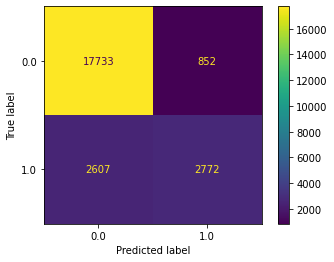

In [ ]:
disp.plot()

In [ ]:
print(17733/(17733 + 852))
print(2772/(2772 + 2607))

0.9541565778853914
0.5153374233128835


Accuracy of the model is good at ~85%, and the model is very good at predicting when it will not rain tomorrow. However, of the ~5000 instances of RainTomorrow = 'Yes', the only predicts about half correctly. This suggests that the model is likely too rigid.

How will changing nestimators change performance?

In [ ]:
#States
ACT = df[df['State'] == "ACT"]
NI = df[df['State'] == "NI"]
NSW = df[df['State'] == "NSW"]
NT = df[df['State'] == "NT"]
QSL = df[df['State'] == "QSL"]
SA = df[df['State'] == "SA"]
TAS = df[df['State'] == "TAS"]
VIC = df[df['State'] == "VIC"]
WA = df[df['State'] == "WA"]

#Seasons
Summer = df[df['Seasons'] == 0]
Fall = df[df['Seasons'] == 1]
Winter = df[df['Seasons'] == 2]
Spring = df[df['Seasons'] == 3]

In [ ]:
def runmodel(dataframe, rand, mode):
  xCols = []
  if mode:
    xCols = [3,4,5,6,7,8,9,10,11,12,13,14,15,16,18]
  else:
    xCols = [1,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
  
  X = dataframe.iloc[:,xCols].values
  Y = dataframe.iloc[:, 17].values
  Y = Y.reshape(-1, 1)

  if mode:
    le1 = LabelEncoder()
    X[:,13] = le1.fit_transform(X[:,13])
  else:
    le1 = LabelEncoder()
    X[:,0] = le1.fit_transform(X[:,0])
    le2 = LabelEncoder()
    X[:,14] = le2.fit_transform(X[:,14])

  le = LabelEncoder()
  Y[:,-1] = le.fit_transform(Y[:,-1])

  Y = np.array(Y, dtype=float)
  X = sc.fit_transform(X)

  X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.20,random_state=rand)
  Y_train = Y_train.reshape(-1,1)

  classifier = RandomForestClassifier(n_estimators=50, random_state=0)
  classifier.fit(X_train, Y_train.ravel())
  print(classifier.score(X_train, Y_train))

  Y_pred = le3.inverse_transform(np.array(classifier.predict(X_test), dtype=int))
  Y_test = le3.inverse_transform(np.array(Y_test,dtype=int))
  Y_pred = Y_pred.reshape(-1, 1)
  Y_test = Y_test.reshape(-1, 1)
  print(accuracy_score(Y_test, Y_pred))

  Y_pred = le3.fit_transform(Y_pred[:,-1])
  Y_test = le3.fit_transform(Y_test[:,-1])
  cm = confusion_matrix(Y_test, Y_pred, labels=classifier.classes_)
  print(cm, "\n")

In [ ]:
import random
stateList = [ACT, NI, NSW, NT, QSL, SA, TAS, VIC, WA]
states = ["ACT", "NI", "NSW", "NT", "QSL", "SA", "TAS", "WA"]
seasonList = [Summer, Fall, Winter, Spring]
seasons = ["Summer", "Fall", "Winter", "Spring"]

for i in range(len(states)):
  print(states[i], "\n")
  randy = random.randint(0,40)
  runmodel(stateList[i], randy, True)

for j in range(len(seasons)):
  print(seasons[j], "\n")
  randy = random.randint(0,20)
  runmodel(seasonList[j], randy, False)


ACT 

0.9987325728770595
0.8682432432432432
[[471   9]
 [ 69  43]] 

NI 



/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1.0
0.7945670628183361
[[377  33]
 [ 88  91]] 

NSW 



/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9994455006337135
0.8492000633613179
[[4701  216]
 [ 736  660]] 

NT 



/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.99946026177304
0.9163518618456556
[[1516   51]
 [ 104  182]] 

QSL 



/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9995849330704576
0.8340248962655602
[[1725  122]
 [ 278  285]] 

SA 



/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.999480087345326
0.8881496881496882
[[1878   92]
 [ 177  258]] 

TAS 



/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1.0
0.8001611603545528
[[864  71]
 [177 129]] 

WA 



/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9997551899725813
0.8574505580575681
[[3720  197]
 [ 531  659]] 

Summer 



/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9995670245930032
0.8649116730169726
[[4459  183]
 [ 597  535]] 

Fall 



/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9996049616812831
0.8606414915468479
[[4731  222]
 [ 660  716]] 

Winter 



/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9996690385570081
0.8510673506536488
[[4166  265]
 [ 635  977]] 

Spring 



/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9993554209101456
0.8528704022000687
[[4375  217]
 [ 639  587]] 



/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


All of the confusion matricies and model accuracies produced by separating the data by state or season were very similar to the original confusion matrix using all available variables. So, either state and season do not strongly affect Rain Tomorrow, or, more  likely, there are too many variables leading to overfitting of the data. Maybe we should take it down a notch.

# Model Set 3: Logisitic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state = 88)

- Daily ranges in temperature, and changes in pressure/humidity should be independent of season or location. We will start our logistic regression with these

In [ ]:
# grabbed maxtemp, mintemp, pressure9am/3pm, humidity9am/3pm
X1 = df.iloc[:, [3,4,12,13,14,15]].values
Y1 = df.iloc[:, [17]].values

le = LabelEncoder()
Y1[:,-1] = le.fit_transform(Y1[:,-1])

Y1 = np.array(Y1, dtype=float)
sc = StandardScaler()
X1 = sc.fit_transform(X1)

X1_train,X1_test,Y1_train,Y1_test = train_test_split(X1,Y1,test_size=0.15,random_state=22)
Y1_train = Y1_train.reshape(-1,1)

In [ ]:
lr.fit(X1_train, Y1_train.ravel())
Y1_predlr = lr.predict(X1_test)
print(lr.score(X1_train, Y1_train))
print(accuracy_score(Y1_test, Y1_predlr))

0.8317524841915086
0.8319145384743782


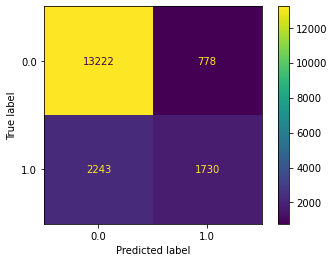

In [ ]:
cm = confusion_matrix(Y1_test, Y1_predlr, labels=lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
disp.plot()

In [ ]:
print(13222/(13222 + 778))
print(1730/(1730 + 2243))

0.9444285714285714
0.43543921469921976


While this model is not overfitted like our first model, the percent of correct "No" is very similar. Unforunately, the percent of correct "Yes" is lower by around 12%, which suggests there are other variables required to better predict rain tomorrow. We'll try percipitation (which gives us rainToday as well as data), windgustspeed/dir, and windspeed9am/3pm.  

In [ ]:
# Add precipitation
X2 = df.iloc[:, [3,4,5,12,13,14,15]].values
X2 = sc.fit_transform(X2)

X2_train,X2_test,Y2_train,Y2_test = train_test_split(X2,Y1,test_size=0.15,random_state=33)
Y2_train = Y2_train.reshape(-1,1)

lr.fit(X2_train, Y2_train.ravel())
Y2_predlr = lr.predict(X2_test)
print(lr.score(X2_train, Y2_train))
print(accuracy_score(Y2_test, Y2_predlr))

0.83380464239425
0.8349746842485951


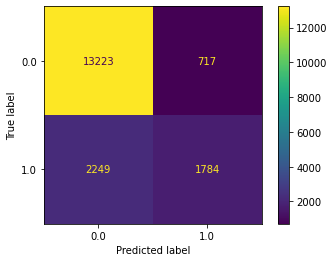

In [ ]:
cm = confusion_matrix(Y2_test, Y2_predlr, labels=lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
disp.plot()

In [ ]:
print(13222/(13222 + 717))
print(1784/(1784 + 2249))

0.9485615897840591
0.4423506074882222


In [ ]:
# Add gust direction and speed
X3 = df.iloc[:, [3,4,6,7,12,13,14,15]].values
X3 = sc.fit_transform(X3)

X3_train,X3_test,Y3_train,Y3_test = train_test_split(X3,Y1,test_size=0.15,random_state=44)
Y3_train = Y3_train.reshape(-1,1)

lr.fit(X3_train, Y3_train.ravel())
Y3_predlr = lr.predict(X3_test)
print(lr.score(X3_train, Y3_train))
print(accuracy_score(Y3_test, Y3_predlr))

0.8394014374926358
0.8371446057975853


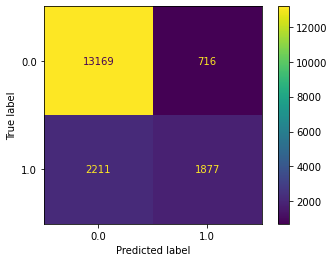

In [ ]:
cm = confusion_matrix(Y3_test, Y3_predlr, labels=lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
disp.plot()

In [ ]:
print(13169/(13169 + 716))
print(1877/(1877+2211))

0.9484335613971913
0.4591487279843444


In [ ]:
# Add wind speed 9am/3pm
X4 = df.iloc[:, [3,4,6,11,12,13,14,15]].values
X4 = sc.fit_transform(X4)

X4_train,X4_test,Y4_train,Y4_test = train_test_split(X4,Y1,test_size=0.15,random_state=55)
Y4_train = Y4_train.reshape(-1,1)

lr.fit(X4_train, Y4_train.ravel())
Y4_predlr = lr.predict(X4_test)
print(lr.score(X4_train, Y4_train))
print(accuracy_score(Y4_test, Y4_predlr))

0.8323907152115
0.829744616925388


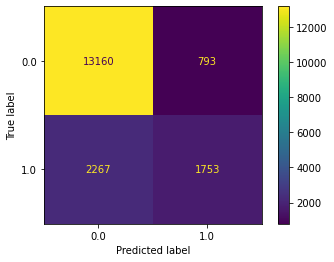

In [ ]:
cm = confusion_matrix(Y4_test, Y4_predlr, labels=lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
disp.plot()

In [ ]:
print(13160/(13160 + 793))
print(1753/(1753+2267))

0.9431663441553788
0.43606965174129353


In [ ]:
# Try state?
X5 = df.iloc[:, [1,3,4,6,13,14,15]].values
le2 = LabelEncoder()
X5[:,0] = le.fit_transform(X5[:,0])
X5 = sc.fit_transform(X5)

X5_train,X5_test,Y5_train,Y5_test = train_test_split(X5,Y1,test_size=0.15,random_state=66)
Y5_train = Y5_train.reshape(-1,1)

lr.fit(X5_train, Y5_train.ravel())
Y5_predlr = lr.predict(X5_test)
print(lr.score(X5_train, Y5_train))
print(accuracy_score(Y5_test, Y5_predlr))

0.8333333333333334
0.8304122850943081


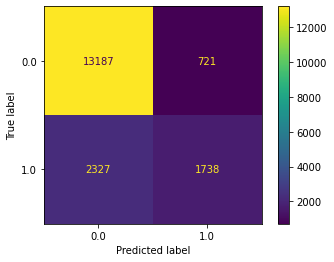

In [ ]:
cm = confusion_matrix(Y5_test, Y5_predlr, labels=lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
disp.plot()

In [ ]:
# Add season?
X6 = df.iloc[:, [3,4,6,13,14,15,18]].values
X6 = sc.fit_transform(X6)

X6_train,X6_test,Y6_train,Y6_test = train_test_split(X6,Y1,test_size=0.15,random_state=77)
Y6_train = Y6_train.reshape(-1,1)

lr.fit(X6_train, Y6_train.ravel())
Y6_predlr = lr.predict(X6_test)
print(lr.score(X6_train, Y6_train))
print(accuracy_score(Y6_test, Y6_predlr))

0.8325281803542673
0.8331942357981417


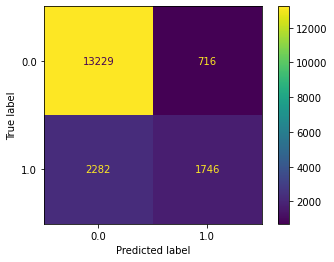

In [ ]:
cm = confusion_matrix(Y6_test, Y6_predlr, labels=lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
disp.plot()

None of these variables have a significant impact on the accuracy of the base logistic model on predicting yes correctly. Separating the data by raining today may show a difference.

In [ ]:
rainingToday = df[df['RainToday'] == 'Yes']
notRainingToday = df[df['RainToday'] == 'No']

In [ ]:
#When its raining today
X7 = rainingToday.iloc[:, [3,4,12,13,14,15]].values
Y7 = rainingToday.iloc[:, [17]].values

Y7[:,-1] = le.fit_transform(Y7[:,-1])

Y7 = np.array(Y7, dtype=float)
X7 = sc.fit_transform(X7)

X7_train,X7_test,Y7_train,Y7_test = train_test_split(X7,Y7,test_size=0.15,random_state=88)
Y7_train = Y7_train.reshape(-1,1)

In [ ]:
lr.fit(X7_train, Y7_train.ravel())
Y7_predlr = lr.predict(X7_test)
print(lr.score(X7_train, Y7_train))
print(accuracy_score(Y7_test, Y7_predlr))

0.7286652078774617
0.7267542772129928


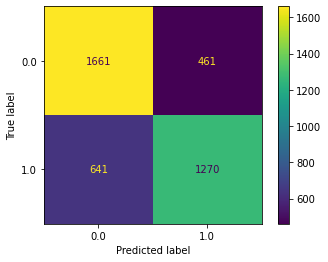

In [ ]:
cm = confusion_matrix(Y7_test, Y7_predlr, labels=lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
disp.plot()

In [ ]:
print(1661/(461+1661))
print(1270/(641+1270))

0.7827521206409048
0.6645735217163788


- The model can accurately predict if it will rain tommorrow 2/3 of the time if it rains today! Thats better than half!

In [ ]:
X8 = notRainingToday.iloc[:, [3,4,12,13,14,15]].values
Y8 = notRainingToday.iloc[:, [17]].values

Y8[:,-1] = le.fit_transform(Y8[:,-1])

Y8 = np.array(Y8, dtype=float)
X8 = sc.fit_transform(X8)

X8_train,X8_test,Y8_train,Y8_test = train_test_split(X8,Y8,test_size=0.15,random_state=11)
Y8_train = Y8_train.reshape(-1,1)
lr.fit(X8_train, Y8_train.ravel())
Y8_predlr = lr.predict(X8_test)
print(lr.score(X8_train, Y8_train))
print(accuracy_score(Y8_test, Y8_predlr))

0.865962806830985
0.8677282834803816


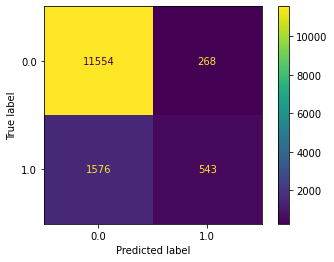

In [ ]:
cm = confusion_matrix(Y8_test, Y8_predlr, labels=lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
disp.plot()

In [ ]:
print(11554/(11554+268))
print(543/(1576+543))

0.9773304009473862
0.25625294950448324


- The model is much better at predicting rain tomorrow if it rained today, it actually appears as this is the largest error the model creates.  Unfortunately, it doesn't rain much more often than it does. How can we fix this?

#Idea: Add Columns That Count Days Since Last Rain And Days Of Consistent Rain
- perhaps having a higher number in either category will make the model more likely to predict tomorrow to either start or stop raining

In [ ]:
SinceLastRain = []
ConsistentRain = []

for city in df.Location.unique():
  tempDF = df[df['Location'] == city]
  tempDF = tempDF.reset_index(drop=True)
  nocount = 0
  yescount = 0

  for i in range(tempDF.shape[0]):
    nocount +=1
    yescount +=1
    if tempDF.loc[i,'RainToday'] == "No":
      yescount = 0
    elif tempDF.loc[i,'RainToday'] == "Yes":
      nocount = 0
    SinceLastRain.append(nocount)
    ConsistentRain.append(yescount)

df['SinceLastRain'] = SinceLastRain
df['ConsistentRain'] = ConsistentRain


In [ ]:
df

,Date,State,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,RainToday,RainTomorrow,Seasons,SinceLastRain,ConsistentRain
0,2008-12-01,NSW,Albury,13.4,22.9,0.6,270.0,44.0,270.0,292.5,...,24.0,71.0,22.0,1007.7,1007.1,No,0,0,1,0
1,2008-12-02,NSW,Albury,7.4,25.1,0.0,292.5,44.0,337.5,247.5,...,22.0,44.0,25.0,1010.6,1007.8,No,0,0,2,0
2,2008-12-03,NSW,Albury,12.9,25.7,0.0,247.5,46.0,270.0,247.5,...,26.0,38.0,30.0,1007.6,1008.7,No,0,0,3,0
3,2008-12-04,NSW,Albury,9.2,28.0,0.0,45.0,24.0,135.0,90.0,...,9.0,45.0,16.0,1017.6,1012.8,No,0,0,4,0
4,2008-12-05,NSW,Albury,17.5,32.3,1.0,270.0,41.0,67.5,315.0,...,20.0,82.0,33.0,1010.8,1006.0,No,0,0,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119812,2017-06-20,NT,Uluru,3.5,21.8,0.0,90.0,31.0,112.5,90.0,...,13.0,59.0,27.0,1024.7,1021.2,No,0,2,60,0
119813,2017-06-21,NT,Uluru,2.8,23.4,0.0,90.0,31.0,135.0,67.5,...,11.0,51.0,24.0,1024.6,1020.3,No,0,2,61,0
119814,2017-06-22,NT,Uluru,3.6,25.3,0.0,337.5,22.0,135.0,0.0,...,9.0,56.0,21.0,1023.5,1019.1,No,0,2,62,0
119815,2017-06-23,NT,Uluru,5.4,26.9,0.0,0.0,37.0,135.0,292.5,...,9.0,53.0,24.0,1021.0,1016.8,No,0,2,63,0


- Now we can try the last two logistic regressions again.

In [ ]:
rainingToday = df[df['RainToday'] == 'Yes']
notRainingToday = df[df['RainToday'] == 'No']

In [ ]:
# added two new columns
X7 = rainingToday.iloc[:, [3,4,12,13,14,15,19,20]].values
Y7 = rainingToday.iloc[:, [17]].values

Y7[:,-1] = le.fit_transform(Y7[:,-1])

Y7 = np.array(Y7, dtype=float)
X7 = sc.fit_transform(X7)

X7_train,X7_test,Y7_train,Y7_test = train_test_split(X7,Y7,test_size=0.15,random_state=88)
Y7_train = Y7_train.reshape(-1,1)

lr.fit(X7_train, Y7_train.ravel())
Y7_predlr = lr.predict(X7_test)
print(lr.score(X7_train, Y7_train))
print(accuracy_score(Y7_test, Y7_predlr))

0.7284026258205689
0.7272501859657823


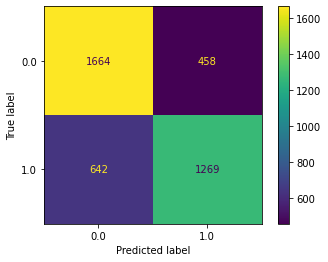

In [ ]:
cm = confusion_matrix(Y7_test, Y7_predlr, labels=lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
disp.plot()

In [ ]:
X8 = notRainingToday.iloc[:, [3,4,12,13,14,15,19,20]].values
Y8 = notRainingToday.iloc[:, [17]].values

Y8[:,-1] = le.fit_transform(Y8[:,-1])

Y8 = np.array(Y8, dtype=float)
X8 = sc.fit_transform(X8)

X8_train,X8_test,Y8_train,Y8_test = train_test_split(X8,Y8,test_size=0.15,random_state=11)
Y8_train = Y8_train.reshape(-1,1)
lr.fit(X8_train, Y8_train.ravel())
Y8_predlr = lr.predict(X8_test)
print(lr.score(X8_train, Y8_train))
print(accuracy_score(Y8_test, Y8_predlr))

0.8658108946362336
0.8675848217487985


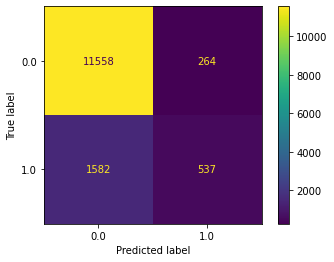

In [ ]:
cm = confusion_matrix(Y8_test, Y8_predlr, labels=lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
disp.plot()

- Turns out this barely changes anything when the models are separated. What about against the original model?

In [ ]:
#add dayswithoutrain and consistent rain
X1 = df.iloc[:, [3,4,12,13,14,15,19,20]].values
Y1 = df.iloc[:, [17]].values

le = LabelEncoder()
Y1[:,-1] = le.fit_transform(Y1[:,-1])

Y1 = np.array(Y1, dtype=float)
X1 = sc.fit_transform(X1)

X1_train,X1_test,Y1_train,Y1_test = train_test_split(X1,Y1,test_size=0.15,random_state=69)
Y1_train = Y1_train.reshape(-1,1)

lr.fit(X1_train, Y1_train.ravel())
Y1_predlr = lr.predict(X1_test)
print(lr.score(X1_train, Y1_train))
print(accuracy_score(Y1_test, Y1_predlr))

0.834197399945014
0.8311912312913815


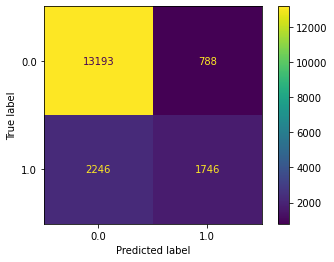

In [ ]:
cm = confusion_matrix(Y1_test, Y1_predlr, labels=lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
disp.plot()

In [ ]:
print(13193/(768+13193))
print(1746/(1746+2246))

0.944989613924504
0.437374749498998


- That was a bust, what about reducing dimensionality?

In [ ]:
#Remove cols 12 and 13 (humidity)
X1 = df.iloc[:, [3,4,14,15,19,20]].values
Y1 = df.iloc[:, [17]].values

le = LabelEncoder()
Y1[:,-1] = le.fit_transform(Y1[:,-1])

Y1 = np.array(Y1, dtype=float)
X1 = sc.fit_transform(X1)

X1_train,X1_test,Y1_train,Y1_test = train_test_split(X1,Y1,test_size=0.15,random_state=69)
Y1_train = Y1_train.reshape(-1,1)

lr.fit(X1_train, Y1_train.ravel())
Y1_predlr = lr.predict(X1_test)
print(lr.score(X1_train, Y1_train))
print(accuracy_score(Y1_test, Y1_predlr))

0.8143238678763599
0.8127190786179269


In [ ]:
#remove 3 and 4, min/maxtemp
X1 = df.iloc[:, [12,13,14,15,19,20]].values
Y1 = df.iloc[:, [17]].values

le = LabelEncoder()
Y1[:,-1] = le.fit_transform(Y1[:,-1])

Y1 = np.array(Y1, dtype=float)
X1 = sc.fit_transform(X1)

X1_train,X1_test,Y1_train,Y1_test = train_test_split(X1,Y1,test_size=0.15,random_state=69)
Y1_train = Y1_train.reshape(-1,1)

lr.fit(X1_train, Y1_train.ravel())
Y1_predlr = lr.predict(X1_test)
print(lr.score(X1_train, Y1_train))
print(accuracy_score(Y1_test, Y1_predlr))

0.8330485841090295
0.8286874756579313


In [ ]:
X1 = df.iloc[:, [3,4,12,13,19,20]].values
X1 = sc.fit_transform(X1)

X1_train,X1_test,Y1_train,Y1_test = train_test_split(X1,Y1,test_size=0.15,random_state=76)
Y1_train = Y1_train.reshape(-1,1)

lr.fit(X1_train, Y1_train.ravel())
Y1_predlr = lr.predict(X1_test)
print(lr.score(X1_train, Y1_train))
print(accuracy_score(Y1_test, Y1_predlr))

0.8282863988060171
0.8290769487564681


#Idea 2: Creating New Cols Based on Differences Could Reduce Model Dimensionality

In [ ]:
differenceDF = pd.DataFrame(columns = ['MinMaxDiff', 'WindDiff', 'HumidityDiff', 'PressureDiff'])
maxMinDiff = []
windDiff = []
humidityDiff = []
pressureDiff = []
outputList = [maxMinDiff, windDiff, humidityDiff, pressureDiff,]
diffColPairs = [['MinTemp', 'MaxTemp'], ['WindSpeed9am', 'WindSpeed3pm'], ['Humidity9am', 'Humidity3pm'], ['Pressure9am', 'Pressure3pm']]

def find_diff(cols, out, index):
  for i in range(df.shape[0]):
    if i % 10000 == 0:
      print(index, "at row", i)
    out.append(round(df.loc[i, cols[1]] - df.loc[i, cols[0]], 1))
  return out

threads = list()
for index in range(4):
  print("Starting: ", index)
  x = threading.Thread(target=find_diff, args=(diffColPairs[index], outputList[index], index,))
  threads.append(x)
  x.start()

for index, thread in enumerate(threads):
  print("Waiting on", index)
  thread.join()
  print(index, "Done")


Starting:  0
0Starting:  1
 at row 0
1Starting:  2
 at row 0
2 at row 0
Starting:  3
3 at row 0
Waiting on 0
2 at row 10000
1 at row 10000
3 0 at row 10000
at row 10000
1 at row 20000
32 at row at row  20000
20000
0 at row 20000
1 at row 30000
20 at row 30000
 at row 30000
3 at row 30000
1 at row 40000
2 at row 040000
 at row 40000
3 at row 40000
1 at row 50000
0 at row 50000
2 at row 50000
3 at row 50000
1 at row 60000
0 at row 60000
2 at row 60000
3 at row 60000
1 at row 70000
0 at row 70000
2 at row 70000
3 at row 70000
1 at row 80000
20  at row 80000
3at row  80000
at row 80000
1 at row 90000
3 at row 90000
0 at row 90000
2 at row 90000
1 at row 100000
3 at row 100000
0 at row 100000
2 at row 100000
1 at row 110000
0 at row 110000
3 at row 110000
2 at row 110000
0 Done
Waiting on 1
1 Done
Waiting on 2
2 Done
Waiting on 3
3 Done


In [ ]:
df['MinMaxDiff'] = maxMinDiff
df['WindDiff'] = windDiff
df['HumidityDiff'] = humidityDiff
df['PressureDiff'] = pressureDiff
df

,Date,State,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure3pm,RainToday,RainTomorrow,Seasons,SinceLastRain,ConsistentRain,MinMaxDiff,WindDiff,HumidityDiff,PressureDiff
0,2008-12-01,NSW,Albury,13.4,22.9,0.6,270.0,44.0,270.0,292.5,...,1007.1,No,0,0,1,0,9.5,4.0,-49.0,-0.6
1,2008-12-02,NSW,Albury,7.4,25.1,0.0,292.5,44.0,337.5,247.5,...,1007.8,No,0,0,2,0,17.7,18.0,-19.0,-2.8
2,2008-12-03,NSW,Albury,12.9,25.7,0.0,247.5,46.0,270.0,247.5,...,1008.7,No,0,0,3,0,12.8,7.0,-8.0,1.1
3,2008-12-04,NSW,Albury,9.2,28.0,0.0,45.0,24.0,135.0,90.0,...,1012.8,No,0,0,4,0,18.8,-2.0,-29.0,-4.8
4,2008-12-05,NSW,Albury,17.5,32.3,1.0,270.0,41.0,67.5,315.0,...,1006.0,No,0,0,5,0,14.8,13.0,-49.0,-4.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119812,2017-06-20,NT,Uluru,3.5,21.8,0.0,90.0,31.0,112.5,90.0,...,1021.2,No,0,2,60,0,18.3,-2.0,-32.0,-3.5
119813,2017-06-21,NT,Uluru,2.8,23.4,0.0,90.0,31.0,135.0,67.5,...,1020.3,No,0,2,61,0,20.6,-2.0,-27.0,-4.3
119814,2017-06-22,NT,Uluru,3.6,25.3,0.0,337.5,22.0,135.0,0.0,...,1019.1,No,0,2,62,0,21.7,-4.0,-35.0,-4.4
119815,2017-06-23,NT,Uluru,5.4,26.9,0.0,0.0,37.0,135.0,292.5,...,1016.8,No,0,2,63,0,21.5,0.0,-29.0,-4.2


#CheckPoint 2
- In case of loss of connection, the dataframe after these edits has been saved separately under checkpoint2.csv. Simply run the last two cells under this checkpoint to resume work from this point on.

In [ ]:
compression_opts = dict(method='zip',archive_name='checkpoint2.csv')
df.to_csv('checkpoint2.zip', index=False, compression=compression_opts)

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import threading
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

drive.mount('/content/drive')
mypath = "/content/drive/My Drive/Colab Notebooks/DS2Project/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv(mypath + "Data/checkpoint2.csv")

#Switching to QDA


In [ ]:
df

,Date,State,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure3pm,RainToday,RainTomorrow,Seasons,SinceLastRain,ConsistentRain,MinMaxDiff,WindDiff,HumidityDiff,PressureDiff
0,2008-12-01,NSW,Albury,13.4,22.9,0.6,270.0,44.0,270.0,292.5,...,1007.1,No,No,0,1,0,9.5,4.0,-49.0,-0.6
1,2008-12-02,NSW,Albury,7.4,25.1,0.0,292.5,44.0,337.5,247.5,...,1007.8,No,No,0,2,0,17.7,18.0,-19.0,-2.8
2,2008-12-03,NSW,Albury,12.9,25.7,0.0,247.5,46.0,270.0,247.5,...,1008.7,No,No,0,3,0,12.8,7.0,-8.0,1.1
3,2008-12-04,NSW,Albury,9.2,28.0,0.0,45.0,24.0,135.0,90.0,...,1012.8,No,No,0,4,0,18.8,-2.0,-29.0,-4.8
4,2008-12-05,NSW,Albury,17.5,32.3,1.0,270.0,41.0,67.5,315.0,...,1006.0,No,No,0,5,0,14.8,13.0,-49.0,-4.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119812,2017-06-20,NT,Uluru,3.5,21.8,0.0,90.0,31.0,112.5,90.0,...,1021.2,No,No,2,60,0,18.3,-2.0,-32.0,-3.5
119813,2017-06-21,NT,Uluru,2.8,23.4,0.0,90.0,31.0,135.0,67.5,...,1020.3,No,No,2,61,0,20.6,-2.0,-27.0,-4.3
119814,2017-06-22,NT,Uluru,3.6,25.3,0.0,337.5,22.0,135.0,0.0,...,1019.1,No,No,2,62,0,21.7,-4.0,-35.0,-4.4
119815,2017-06-23,NT,Uluru,5.4,26.9,0.0,0.0,37.0,135.0,292.5,...,1016.8,No,No,2,63,0,21.5,0.0,-29.0,-4.2


In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc

y = df['RainTomorrow'].values.reshape(-1,1)
x = df.drop(['Date', 'State', 'Location', 'RainToday','RainTomorrow'], axis=1)

le = LabelEncoder()
y[:,-1] = le.fit_transform(y[:,-1])
y = np.array(y, dtype=float)

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2, random_state=42)


In [ ]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(x_train, y_train.ravel())
y_prob_qda = qda.predict_proba(x_test)[:,1]
y_pred = np.where(y_prob_qda > 0.5, 1, 0)

In [ ]:
qda_conf_mat = confusion_matrix(y_test, y_pred)
qda_conf_mat

array([[16694,  1849],
       [ 2688,  2733]])

In [ ]:
print("Correct No Rain:")
print(16694/(16694+1849))
print("\nCorrect Rain:")
print(2733/(2688+2733))

Correct No Rain:
0.9002858221431268

Correct Rain:
0.5041505257332596


In [ ]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,y_prob_qda)
roc_auc_qda = auc(false_positive_rate, true_positive_rate)
roc_auc_qda

0.8295968479531708

In [ ]:
def plot_roc(roc_auc):
  plt.figure(figsize=(7,7))
  plt.title('REciever Operating Characteristic')
  plt.plot(false_positive_rate, true_positive_rate, color='red', label='AUC = %0.2f' % roc_auc)
  plt.legend(loc='lower right')
  plt.plot([0,1], [0,1], linestyle='--')
  plt.axis('tight')
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')

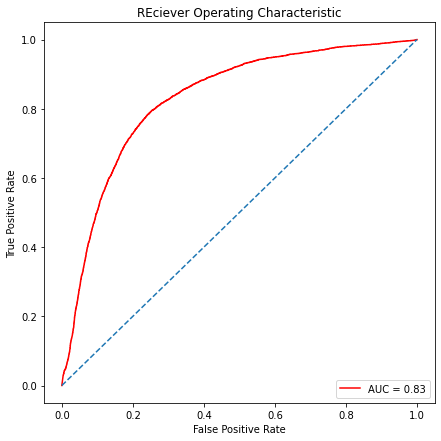

In [ ]:
plot_roc(roc_auc_qda)

- Use scalar on X data

In [ ]:
x0 = sc.fit_transform(x)
x0_train,x0_test,y0_train,y0_test = train_test_split(x0,y,test_size=0.2, random_state=42)

qda.fit(x0_train, y0_train.ravel())
y0_prob_qda = qda.predict_proba(x0_test)[:,1]
y0_pred = np.where(y0_prob_qda > 0.5, 1, 0)
qda_conf_mat = confusion_matrix(y_test, y0_pred)
qda_conf_mat

array([[16694,  1849],
       [ 2688,  2733]])

In [ ]:
print(16694/(1849+16694))
print(2733/(2688+2733))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,y_prob_qda)
roc_auc_qda = auc(false_positive_rate, true_positive_rate)
print(roc_auc_qda)
      

0.9002858221431268
0.5041505257332596
0.8295968479531708


- Scaling data before QDA has no impact

- Lets try reducing dimensionality of model

In [ ]:
#using the differences between
xa = df.iloc[:, [1, 5, 18,19,20,21,22,23,24]].values
#encode label for state
le1 = LabelEncoder()
xa[:,0] = le1.fit_transform(xa[:,0])

xa_train,xa_test,ya_train,ya_test = train_test_split(xa,y,test_size=0.2, random_state=32)
qda.fit(xa_train, ya_train.ravel())
ya_prob_qda = qda.predict_proba(xa_test)[:,1]
ya_pred = np.where(ya_prob_qda > 0.5, 1, 0)

qda_conf_mat = confusion_matrix(ya_test, ya_pred)
qda_conf_mat

array([[17281,  1299],
       [ 3579,  1805]])

In [ ]:
print("Correct No Rain:")
print(17281/(17281+1299))
print("\nCorrect Rain:")
print(1805/(3579+1805))

Correct No Rain:
0.930086114101184

Correct Rain:
0.3352526002971768


- This is worse unfortunately.

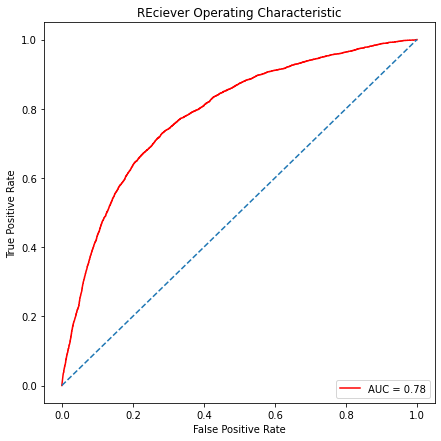

In [ ]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(ya_test,ya_prob_qda)
roc_auc_qda = auc(false_positive_rate, true_positive_rate)
roc_auc_qda
plot_roc(roc_auc_qda)

- AUC is smaller than before, either these variables are not as influenctial, or reducing the dimesionality leads to lower accuracy of the model.